# IMDB Sentiment Analysis

This notebook builds a simple sentiment classifier using **sentence-level lexicon features** (VADER + TextBlob) and a **multi-layer perceptron (MLP)**.
It saves:

- `model/best_model.pkl`
- `results/confusion_matrix.png`
- `results/loss_curves.png`

Repo structure:


IMDB-Sentiment-Analysis/
├─ notebooks/notebook.ipynb
├─ IMDB Dataset.csv
├─ model/best_model.pkl
├─ results/loss_curves.png 
          /confusion_matrix.png



In [1]:
!pip install pandas numpy matplotlib scikit-learn vaderSentiment textblob joblib



Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import joblib

RANDOM_STATE = 42
analyzer = SentimentIntensityAnalyzer()


## 1) Load Dataset

In [3]:

DATA_PATH = os.path.join("..", "IMDB Dataset.csv")

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"Could not find dataset at {DATA_PATH}. "
        "Place 'IMDB Dataset.csv' in the project root."
    )

df = pd.read_csv(DATA_PATH)
df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.info()


<class 'pandas.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   review     50000 non-null  str  
 1   sentiment  50000 non-null  str  
dtypes: str(2)
memory usage: 781.4 KB


## 2) Quick EDA

In [5]:
# Class distribution
df["sentiment"].value_counts()


sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [6]:
# Basic text length stats
lengths = df["review"].astype(str).str.len()
lengths.describe()


count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: review, dtype: float64

## 3) Preprocessing + Feature Engineering (Sentence-level)

We only use **sentence-level** lexicon features:
- VADER compound score
- TextBlob polarity
- |VADER - TextBlob| 


In [7]:
def clean_text(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"<.*?>", " ", s)          # remove HTML tags
    s = re.sub(r"\s+", " ", s).strip()   # normalize spaces
    return s

def vader_compound(s: str) -> float:
    return analyzer.polarity_scores(s)["compound"]

def textblob_polarity(s: str) -> float:
    return float(TextBlob(s).sentiment.polarity)

def build_features(text_series: pd.Series) -> pd.DataFrame:
    cleaned = text_series.map(clean_text)
    vader_scores = cleaned.map(vader_compound)
    tb_scores = cleaned.map(textblob_polarity)
    return pd.DataFrame({
        "vader": vader_scores,
        "textblob": tb_scores,
        "abs_gap": (vader_scores - tb_scores).abs(),
    })


In [8]:
X = build_features(df["review"])
y = (df["sentiment"].str.lower() == "positive").astype(int)

X.head(), y.value_counts()


(    vader  textblob   abs_gap
 0 -0.9916  0.023433  1.015033
 1  0.9670  0.109722  0.857278
 2  0.9745  0.360960  0.613540
 3 -0.9213  0.004167  0.925467
 4  0.9766  0.214483  0.762117,
 sentiment
 1    25000
 0    25000
 Name: count, dtype: int64)

## 4) Train/Val/Test Split

In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=RANDOM_STATE, stratify=y_temp
)

len(X_train), len(X_val), len(X_test)


(35000, 7500, 7500)

## 5) MLP Model (Multi-Layer Perceptron)

Changeables 
- `hidden_layer_sizes`
- `alpha`
- `max_iter`
- `learning_rate_init`


In [10]:
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    batch_size=256,
    learning_rate_init=1e-3,
    max_iter=25,
    random_state=RANDOM_STATE,
    verbose=True
)

mlp.fit(X_train, y_train)


Iteration 1, loss = 0.55564977
Iteration 2, loss = 0.48631364
Iteration 3, loss = 0.47846844
Iteration 4, loss = 0.47776237
Iteration 5, loss = 0.47723099
Iteration 6, loss = 0.47757143
Iteration 7, loss = 0.47657001
Iteration 8, loss = 0.47628929
Iteration 9, loss = 0.47630959
Iteration 10, loss = 0.47614096
Iteration 11, loss = 0.47590289
Iteration 12, loss = 0.47578232
Iteration 13, loss = 0.47606722
Iteration 14, loss = 0.47522500
Iteration 15, loss = 0.47532903
Iteration 16, loss = 0.47541215
Iteration 17, loss = 0.47545987
Iteration 18, loss = 0.47507341
Iteration 19, loss = 0.47510552
Iteration 20, loss = 0.47474196
Iteration 21, loss = 0.47471786
Iteration 22, loss = 0.47483258
Iteration 23, loss = 0.47484446
Iteration 24, loss = 0.47458533
Iteration 25, loss = 0.47485725


C:\Users\Administrator\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


,"hidden_layer_sizes hidden_layer_sizes: array-like of shape(n_layers - 2,), default=(100,)The ith element represents the number of neurons in the ithhidden layer.","(64, ...)"
,"activation activation: {'identity', 'logistic', 'tanh', 'relu'}, default='relu'Activation function for the hidden layer.- 'identity', no-op activation, useful to implement linear bottleneck, returns f(x) = x- 'logistic', the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).- 'tanh', the hyperbolic tan function, returns f(x) = tanh(x).- 'relu', the rectified linear unit function, returns f(x) = max(0, x)",'relu'
,"solver solver: {'lbfgs', 'sgd', 'adam'}, default='adam'The solver for weight optimization.- 'lbfgs' is an optimizer in the family of quasi-Newton methods.- 'sgd' refers to stochastic gradient descent.- 'adam' refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy BaFor a comparison between Adam optimizer and SGD, see:ref:`sphx_glr_auto_examples_neural_networks_plot_mlp_training_curves.py`.Note: The default solver 'adam' works pretty well on relativelylarge datasets (with thousands of training samples or more) in terms ofboth training time and validation score.For small datasets, however, 'lbfgs' can converge faster and performbetter.",'adam'
,"alpha alpha: float, default=0.0001Strength of the L2 regularization term. The L2 regularization termis divided by the sample size when added to the loss.For an example usage and visualization of varying regularization, see:ref:`sphx_glr_auto_examples_neural_networks_plot_mlp_alpha.py`.",0.0001
,"batch_size batch_size: int, default='auto'Size of minibatches for stochastic optimizers.If the solver is 'lbfgs', the classifier will not use minibatch.When set to ""auto"", `batch_size=min(200, n_samples)`.",256
,"learning_rate learning_rate: {'constant', 'invscaling', 'adaptive'}, default='constant'Learning rate schedule for weight updates.- 'constant' is a constant learning rate given by 'learning_rate_init'.- 'invscaling' gradually decreases the learning rate at each time step 't' using an inverse scaling exponent of 'power_t'. effective_learning_rate = learning_rate_init / pow(t, power_t)- 'adaptive' keeps the learning rate constant to 'learning_rate_init' as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if 'early_stopping' is on, the current learning rate is divided by 5.Only used when ``solver='sgd'``.",'constant'
,"learning_rate_init learning_rate_init: float, default=0.001The initial learning rate used. It controls the step-sizein updating the weights. Only used when solver='sgd' or 'adam'.",0.001
,"power_t power_t: float, default=0.5The exponent for inverse scaling learning rate.It is used in updating effective learning rate when the learning_rateis set to 'invscaling'. Only used when solver='sgd'.",0.5
,"max_iter max_iter: int, default=200Maximum number of iterations. The solver iterates until convergence(determined by 'tol') or this number of iterations. For stochasticsolvers ('sgd', 'adam'), note that this determines the number of epochs(how many times each data point will be used), not the number ofgradient steps.",25
,"shuffle shuffle: bool, default=TrueWhether to shuffle samples in each iteration. Only used whensolver='sgd' or 'adam'.",True
,"random_state random_state: int, RandomState instance, default=NoneDetermines random number generation for weights and biasinitialization, train-test split if early stopping is used, and batchsampling when solver='sgd' or 'adam'.Pass an int for reproducible results across multiple function calls.See :term:`Glossary `.",42


## 6) Evaluation

In [11]:
def evaluate(model, X_split, y_split, split_name="split", threshold=0.5):
    proba = model.predict_proba(X_split)[:, 1]
    pred = (proba >= threshold).astype(int)
    acc = accuracy_score(y_split, pred)
    cm = confusion_matrix(y_split, pred)
    print(f"{split_name} accuracy: {acc:.4f}")
    print("Confusion matrix:\n", cm)
    print("\nClassification report:\n", classification_report(y_split, pred, target_names=["neg","pos"]))
    return acc, cm

val_acc, val_cm = evaluate(mlp, X_val, y_val, "Validation")
test_acc, test_cm = evaluate(mlp, X_test, y_test, "Test")


Validation accuracy: 0.7784
Confusion matrix:
 [[2969  781]
 [ 881 2869]]

Classification report:
               precision    recall  f1-score   support

         neg       0.77      0.79      0.78      3750
         pos       0.79      0.77      0.78      3750

    accuracy                           0.78      7500
   macro avg       0.78      0.78      0.78      7500
weighted avg       0.78      0.78      0.78      7500

Test accuracy: 0.7701
Confusion matrix:
 [[2927  823]
 [ 901 2849]]

Classification report:
               precision    recall  f1-score   support

         neg       0.76      0.78      0.77      3750
         pos       0.78      0.76      0.77      3750

    accuracy                           0.77      7500
   macro avg       0.77      0.77      0.77      7500
weighted avg       0.77      0.77      0.77      7500



## 7) Save(model + results)

In [12]:
# Ensure output dirs exist
os.makedirs(os.path.join("..", "results"), exist_ok=True)
os.makedirs(os.path.join("..", "model"), exist_ok=True)

# Save model
joblib.dump(mlp, os.path.join("..", "model", "best_model.pkl"))


# Confusion matrix plot (test)
fig = plt.figure()
plt.imshow(test_cm)
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0,1], ["neg","pos"])
plt.yticks([0,1], ["neg","pos"])
for (i, j), v in np.ndenumerate(test_cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.tight_layout()
plt.savefig(os.path.join("..", "results", "confusion_matrix.png"), dpi=200)
plt.close(fig)

# Loss curve plot (sklearn stores loss_ over iterations)
if hasattr(mlp, "loss_curve_"):
    fig = plt.figure()
    plt.plot(mlp.loss_curve_)
    plt.title("Training Loss Curve")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.savefig(os.path.join("..", "results", "loss_curves.png"), dpi=200)
    plt.close(fig)



print("Saved:")
print(" -", os.path.join("..", "model", "best_model.pkl"))
print(" -", os.path.join("..", "results", "confusion_matrix.png"))
print(" -", os.path.join("..", "results", "loss_curves.png"))


Saved:
 - ..\model\best_model.pkl
 - ..\results\confusion_matrix.png
 - ..\results\loss_curves.png


## 8) Evaluation and Reporting (Accuracy, Loss Curves, Confusion Matrix, Discussion)

In this section, we summarize model performance on the validation/test sets using:
- Accuracy
- Loss curve (training)
- Confusion matrix (test)
- Brief discussion of results

In [13]:
# Print accuracies
print(f"Validation accuracy: {val_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

print("\nTest classification report:\n")
print(classification_report(y_test, (mlp.predict_proba(X_test)[:,1] >= 0.5).astype(int),
      target_names=["neg", "pos"]))


Validation accuracy: 0.7784
Test accuracy: 0.7701

Test classification report:

              precision    recall  f1-score   support

         neg       0.76      0.78      0.77      3750
         pos       0.78      0.76      0.77      3750

    accuracy                           0.77      7500
   macro avg       0.77      0.77      0.77      7500
weighted avg       0.77      0.77      0.77      7500



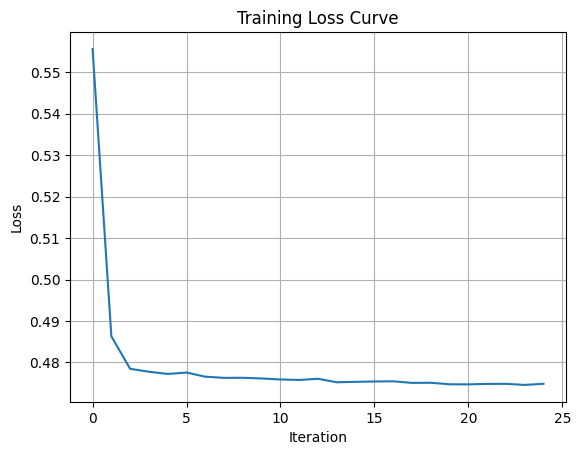

In [14]:
# Display the loss curve
plt.figure()
plt.plot(mlp.loss_curve_)
plt.title("Training Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


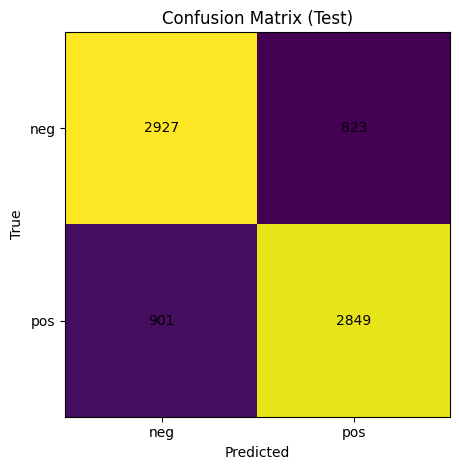

In [15]:
# Plot confusion matrix
cm = confusion_matrix(y_test, (mlp.predict_proba(X_test)[:,1] >= 0.5).astype(int))

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0, 1], ["neg", "pos"])
plt.yticks([0, 1], ["neg", "pos"])

for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")

plt.tight_layout()
plt.show()


### Brief Results Discussion

- The model achieves around **77% accuracy** on the test set using only lexicon-based sentence-level features (VADER + TextBlob).
- The confusion matrix shows a similar number of mistakes in both directions, meaning the model is not strongly biased toward one class.
- Most errors likely come from cases where lexicon scores fail (sarcasm, long reviews with mixed sentiment, strong negations).
- A simple improvement would be adding extra sentence-level features such as TextBlob subjectivity, VADER pos/neg/neu, and review length, or tuning the probability threshold (e.g., 0.45–0.55).


In [ ]:
import pandas as pd

# Create predictions (on the TEST)
proba = mlp.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

submission = pd.DataFrame({
    "id": X_test.index,      # row ids
    "prediction": pred       # 0 = neg, 1 = pos
})

# Save 
submission.to_csv("../submission.csv", index=False)

print("Created submission.csv ")


Created submission.csv 
